# Restricted Boltzmann Machine - MNIST

## Imports

In [1]:
import sys, datetime
import os
from numba import njit, prange
from helper import *
import itertools as it

import numpy as np
from numpy import exp,sqrt,log,log10,sign,power,cosh,sinh,tanh,floor
rng = np.random.default_rng(12345)
np.set_printoptions(precision=4)

import matplotlib as mpl
%matplotlib inline
from matplotlib.ticker import NullFormatter, MaxNLocator, MultipleLocator
mpl.rcParams.update({"font.size": 12})
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

## Load data

In [2]:
X_original, Y_original = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

## Parameters

In [3]:
################################
#    CHOICE OF PARAMETERS      #
################################
# number of MNIST digits to keep (e.g., Ndigit=3 keeps 0,1,2)
Ndigit=3
# number of hidden units

dname='DATA/'
################################


## Select data, and digitalize them two levels

In [4]:
# Selecting digits to use
list_10_digits = ('0','1','2','3','4','5','6','7','8','9')
list_digits = list_10_digits[-Ndigit:] 
print('Chosen digits: ',list_digits)

# keep only X and Y in list_digitssssssssss
keep=np.isin(Y_original, list_digits)
X_keep,Y=X_original[keep],Y_original[keep]


#data,label = MNIST_bit(X_keep, x_min = x_min),Y
#data,label = data.astype("int"),label.astype("int")

# number of data points
#Nd = len(data)
# number of visible units - I.e. total pixels of the image
#D  = len(data[1])


Chosen digits:  ('7', '8', '9')


## Plotting data

In [5]:
#print(f"Extract of MNIST-{Ndigit} data points, binarized")
#for i in range(4): show_MNIST(data[i*20:],Nex=20)

## Contrastive divergence (CD)


In [6]:
# eq(213) page 97, activation via sigmoid
# taking into account energy gap 2 for "spin" variables (-1,1)
#@jit(parallel=True)
def CD_step(v_in,wei,bias, a_func=np.exp, details=False,POTTS=False):
    """
        Generates the state on the other layer: 
        Field "H" ->  activation "a" -> probability "p" -> Spins/bits v_out

        Either (v_in=x, wei=w) or (v_in=z, wei=w.T)

        details = True --> returns also probability (p) and activation (a) 

        POTTS means one-hot encoding (used only in hidden space)
    """
    # local "field"
    H = np.clip(np.dot(v_in.astype(np.float64), wei) + bias, a_min=-300, a_max=300)
    # "activation" note, it is a sigmoid
    a = a_func(level_gap*H)
    n = np.shape(H)
    v_out = np.full(n, x_min, dtype=int) # initially, just a list on -1's or 0's
    if POTTS: # RBM with a single hidden unit = 1 (that is, "one-hot encoding" with L states)
        # p: state probability, normalized to 1 over all units=states
        
        # Probability of turning on a hidden unit
        p = a/np.sum(a)
        # F: cumulative probability
        F = np.cumsum(p)
        # pick a state "i" randomly with probability p[i]
        r = np.random.rand()
        i = 0
        while r>F[i]:
            i+=1
        v_out[i] = 1 # activate a single hidden unit
    else: # normal Ising RBM
        # p: local probability, normalized to 1 for each hidden unit
        p = a / (a + 1.)
        # at each position i, activate the 1's with local probability p[i]
        v_out[np.random.random_sample(n) < p] = 1 

    if details: return (v_out,p,a)
    else: return v_out

## Plot weights

## Weights initialization 
The initialization proposed by Hinton for the bias $a_i$ of a visible unit $v_i$ is given by the formula $ a_i = \log(\frac{p_i}{1-p_i})$ (Hinton 2012), where $p_i$ is the fraction of training samples in which the unit $i$ is on. 
When updating the visible states, $p_i$ corresponds to the probability of having a visible state equal to 1, which is used to stochastically pick the value of each visible unit. The probability of activation for a visible neuron is $P(x_i=1|h)= \sigma(a_i + \sum_j h_j w_{ij})$ (Hinton 2012) where $\sigma(x) = \frac{1}{1+e^{-x}}$ is a sigmoid function. If we set $w_{ij}\sim 0$, we have $P(x_i=1) \sim \sigma(a_i)$, hence $\sigma(a_i) = p_i$.

The biases are set so that the neurons have on average an activation that matches the distribution of the training data (Mehta 2019). This helps stabilize learning and prevents the model from learning too slowly.
In a qualitative way, if a pixel is often active in the dataset ($p\sim 1$), the bias will be higly positive, encouraging the neuron to be active. On the contrary, if a pixel is rarely active ($p_i \sim 0$), the bias will be highly negative, discouraging activation. If $p_i = 0.5$, the bias will be zero, meaning the neuron has a neutral activation probability.

In the function $Hinton$ _ $bias$ _ $init(x)$ , an average on the data is made for each column obtaining the vector xmean.
The vector is then 'refined' setting values that are too close to the lower ($-1$ or $0$) and upper (1) state to a higher (first case) or lower value (second case). This is to avoid divergences when computing the logarithms. 
Finally, the function returns the vector of biases based on the formula above.

In [7]:
# initial bias of visible units, based on their average value in the dataset
# Hinton, "A Practical Guide to Training Restricted Boltzmann Machines"
def Hinton_bias_init(x):
    '''
    x ::shape of 'x'(data): (21770,784)
    xmean :: does the mean on 'data' for each column -> shape of xmean :(,784)
     xmin =0, xmax=1 if SPINS=FALSE, otherwise {-1,+1}
    since np.precision is set at 4 -> S = 1e-4
    level_gap :: is the difference in values between the max (1) and the min (x_min)
    np.clip :: avoid minimum maximum overflow, inf and -inf values.
    '''
    xmean=np.array(np.mean(x,axis=0))
    # remove values at extrema, to avoid divergences in the log's
    S = 1e-4
    x1,x2 = x_min+S,1-S 
    xmean[xmean<x1] = x1
    xmean[xmean>x2] = x2
    return (1/level_gap)*np.clip(log(xmean-x_min) - log(1-xmean),-300,300)
    


## Log-Likelihood


We trained the RBM on digits 7,8,9, trying with number of hidden units L $\in [3,4,5,6,7]$, and for each value we tried different CD steps, $Nt \in [2,4,6,8,10,12]$.

Log-likelihood generally increases during training, what you can see in the resume above are graphs of the LL taken every 5 epochs to spare us computational time and get as soon as possible an overview.

What we see is that number of CD steps matters a little bit in LL increase, 2-3 points, and it depends more on the number of hidden units. Best final values are for L=7. It is interesting to see that sometimes LL stalls after a initial steep increase. This could mean that the model fits the data soon, and then keeps wandering in the hyperspace. 

As Hinton suggests, best results with multidimensional data are reached with more hidden units than the necessary bits to describe the label, but would be optimal to have the same number of hidden units as the length of the data vector. With our computational capabilities this is very difficult to realize, it would mean 20-30 hidden units.



In [8]:
def generate_configurations(L):
    """Generate all binary configurations of length L."""
    return np.array(list(it.product((0,1), repeat=L)), dtype=np.int64)

def compute_log_likelihood(partition,data, a, b, w, configurations):
    log_likelihoods = np.zeros(len(data))  # Preallocate array
    #all_conf = generate_configurations(L)  # Compute binary configs once

    Hz_cache = np.array([H(a,w,z.astype(np.float64)) for z in configurations])  # Precompute H(z)

    for i, x in enumerate(data): 
        Z_x = 0.0
        for Hz, z in zip(Hz_cache, configurations):
            E_xz = -np.dot(Hz, x) - np.dot(b, z)
            Z_x += np.exp(-E_xz)

        log_likelihoods[i] = np.clip(np.log(Z_x) - partition, a_min=-700, a_max=+7000)

    return np.mean(log_likelihoods)

@njit(parallel=True)
def H(a,w,z):  
    return a + np.dot(w, z)  

@njit(parallel=True)
def G(b,z):  
    return np.prod(np.exp(b * z))

@njit(parallel=True)
def partition_function(a,w,b,configurations):
    sum_values = np.zeros(1, dtype=np.float64)#0.0  # Use scalar accumulation

    for i in prange(configurations.shape[0]):
        z = configurations[i]
        Hz = H(a,w,z.astype(np.float64))
        produttoria_H = np.prod(1 + np.exp(Hz))
        sum_values += G(b,z.astype(np.float64)) * produttoria_H

    return np.log(sum_values[0])

## Setting up RBM for cross validation

We use the same code used for training to perform a cross validation. This time we only select the 6 best models from the previous discussion.
In the code below are shown the hyperparameters of the last best model (number 5).

In [28]:
import time
## Hyper parameters::
L = 8
print(f'L, hidden units: {L}')

SPINS = False
print(f'SPINS: {SPINS}')

POTTS = False
print(f'POTTS: {POTTS}')

active = np.exp
print(f'activation func: {active}')

gamma = .001
print(f'gamma: {gamma}')

GRAD = 'RMSprop'
print(f'GRADa: {GRAD}')

# number of CD steps
Nt = 5
print(f'Nt: {Nt}')

Nepoch = 150
print(f'Epochs: {Nepoch}')

# number of minis
Nmini = 300
print(f'Nmini: {Nmini}')

N_ini = 10
print(f'Nini: {N_ini}')

N_fin = 30
print(f'Nfin: {N_fin}')

## momentum
m = .5
print(f'm: {m}')

M = .9
print(f'Final m: {M}')
      
## setup for gradient choice & gamma, momentum
if GRAD=="SGD":
    l_rate_ini,l_rate_fin=1.0,0.25
elif GRAD=="RMSprop":
    beta,epsilon=0.9,1e-4
    #l_rate_ini,l_rate_fin=0.05,0.05
    l_rate_ini,l_rate_fin=0.005,0.002
    print("epsilon=",epsilon)
else:
    l_rate_ini,l_rate_fin=0.05,0.05
    beta1, beta2, epsilon = .9, .999, 1e-4

##setup for spin/potts/other thing
if SPINS:
    x_min=-1
    level_gap=2.
else:
    x_min=0
    level_gap=1.

if POTTS:
    str_simul="RBM_Potts"
    Nz=L
else:
    str_simul="RBM"
    Nz=2**L
    
if POTTS and SPINS: 
    print("\n\n>>>>>>>> WARNING:  POTTS and SPINS cannot coexist\n\n")

# data binarization
data,label = MNIST_bit(X_keep),Y
data,label = data.astype("int"),label.astype("int")
# number of data points
Nd = len(data)
# number of visible units - I.e. total pixels of the image
D  = len(data[1])

# range of each initial weight
# Glorot and Bengio, "Understanding the difficulty of training deep feedforward neural networks"
sigma = sqrt(4. / float(L + D))

print(f"D={D}\tsample size\nL={L}\tnr. z states")
print("Gradient descent type:",GRAD)
print(f"learning rate        = {l_rate_ini} --> {l_rate_fin}")
if gamma!=0: print(f"gamma={gamma}\tregularization")

L, hidden units: 8
SPINS: False
POTTS: False
activation func: <ufunc 'exp'>
gamma: 0.001
GRADa: RMSprop
Nt: 5
Epochs: 150
Nmini: 300
Nini: 10
Nfin: 30
m: 0.5
Final m: 0.9
epsilon= 0.0001
Dataset with 21076 points, each with 784 bits

D=784	sample size
L=8	nr. z states
Gradient descent type: RMSprop
learning rate        = 0.005 --> 0.002
gamma=0.001	regularization


## CV Run

We perform the cross validation by running the learning algorithm using different random seeds. 

Nepoch=150
Nmini=300


<Figure size 640x480 with 0 Axes>

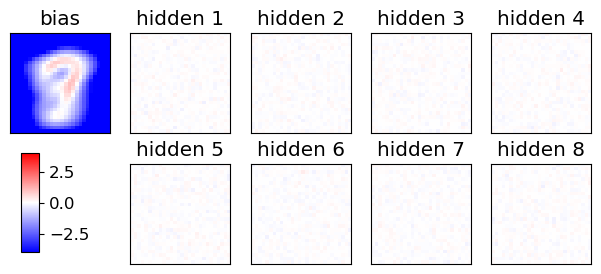

Starting the training
_20250328_2309
epoch 1 / 150  Nt: 5  N: 10  L: 8  rate: 0.005  m: 0.5 SPINS= False POTTS= False
epoch 2 / 150  Nt: 5  N: 10  L: 8  rate: 0.00497986577181208  m: 0.5000180172064321 SPINS= False POTTS= False
epoch 3 / 150  Nt: 5  N: 10  L: 8  rate: 0.0049597315436241615  m: 0.5000720688257285 SPINS= False POTTS= False
epoch 4 / 150  Nt: 5  N: 10  L: 8  rate: 0.004939597315436242  m: 0.5001621548578893 SPINS= False POTTS= False
epoch 5 / 150  Nt: 5  N: 10  L: 8  rate: 0.004919463087248322  m: 0.5002882753029143 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

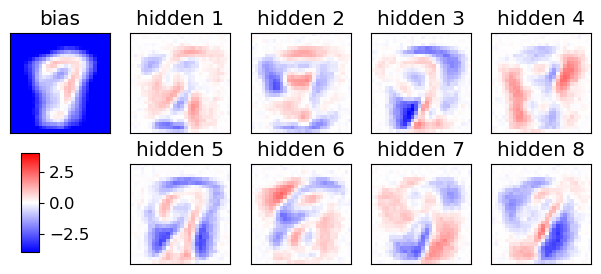

epoch 6 / 150  Nt: 5  N: 10  L: 8  rate: 0.004899328859060403  m: 0.5004504301608036 SPINS= False POTTS= False
epoch 7 / 150  Nt: 5  N: 10  L: 8  rate: 0.0048791946308724835  m: 0.5006486194315571 SPINS= False POTTS= False
epoch 8 / 150  Nt: 5  N: 10  L: 8  rate: 0.004859060402684564  m: 0.500882843115175 SPINS= False POTTS= False
epoch 9 / 150  Nt: 5  N: 10  L: 8  rate: 0.004838926174496644  m: 0.5011531012116571 SPINS= False POTTS= False
epoch 10 / 150  Nt: 5  N: 10  L: 8  rate: 0.004818791946308725  m: 0.5014593937210036 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

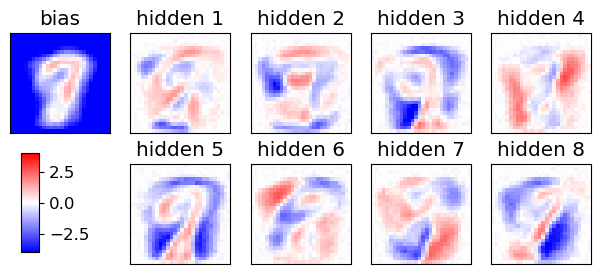

epoch 11 / 150  Nt: 5  N: 10  L: 8  rate: 0.0047986577181208055  m: 0.5018017206432143 SPINS= False POTTS= False
epoch 12 / 150  Nt: 5  N: 10  L: 8  rate: 0.004778523489932886  m: 0.5021800819782892 SPINS= False POTTS= False
epoch 13 / 150  Nt: 5  N: 10  L: 8  rate: 0.004758389261744967  m: 0.5025944777262286 SPINS= False POTTS= False
epoch 14 / 150  Nt: 5  N: 10  L: 8  rate: 0.004738255033557047  m: 0.5030449078870322 SPINS= False POTTS= False
epoch 15 / 150  Nt: 5  N: 10  L: 8  rate: 0.004718120805369127  m: 0.5035313724607 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

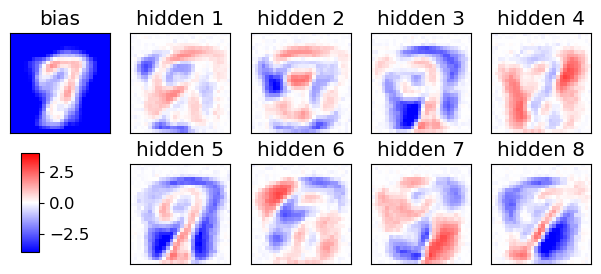

epoch 16 / 150  Nt: 5  N: 10  L: 8  rate: 0.0046979865771812086  m: 0.5040538714472321 SPINS= False POTTS= False
epoch 17 / 150  Nt: 5  N: 10  L: 8  rate: 0.004677852348993289  m: 0.5046124048466285 SPINS= False POTTS= False
epoch 18 / 150  Nt: 5  N: 10  L: 8  rate: 0.004657718120805369  m: 0.5052069726588893 SPINS= False POTTS= False
epoch 19 / 150  Nt: 5  N: 10  L: 8  rate: 0.004637583892617449  m: 0.5058375748840143 SPINS= False POTTS= False
epoch 20 / 150  Nt: 5  N: 10  L: 8  rate: 0.0046174496644295305  m: 0.5065042115220035 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

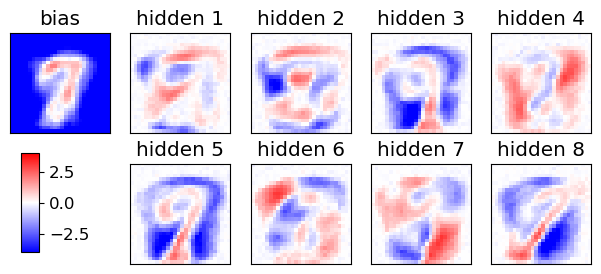

epoch 21 / 150  Nt: 5  N: 10  L: 8  rate: 0.004597315436241611  m: 0.5072068825728571 SPINS= False POTTS= False
epoch 22 / 150  Nt: 5  N: 10  L: 8  rate: 0.004577181208053691  m: 0.507945588036575 SPINS= False POTTS= False
epoch 23 / 150  Nt: 5  N: 10  L: 8  rate: 0.004557046979865772  m: 0.508720327913157 SPINS= False POTTS= False
epoch 24 / 150  Nt: 5  N: 10  L: 8  rate: 0.0045369127516778525  m: 0.5095311022026034 SPINS= False POTTS= False
epoch 25 / 150  Nt: 5  N: 10  L: 8  rate: 0.004516778523489933  m: 0.5103779109049142 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

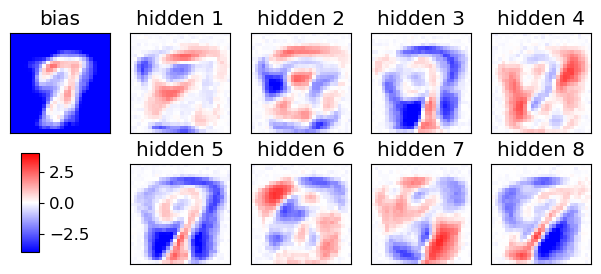

epoch 26 / 150  Nt: 5  N: 10  L: 8  rate: 0.004496644295302013  m: 0.5112607540200892 SPINS= False POTTS= False
epoch 27 / 150  Nt: 5  N: 10  L: 8  rate: 0.004476510067114094  m: 0.5121796315481285 SPINS= False POTTS= False
epoch 28 / 150  Nt: 5  N: 10  L: 8  rate: 0.0044563758389261745  m: 0.513134543489032 SPINS= False POTTS= False
epoch 29 / 150  Nt: 5  N: 10  L: 8  rate: 0.004436241610738255  m: 0.5141254898427998 SPINS= False POTTS= False
epoch 30 / 150  Nt: 5  N: 10  L: 8  rate: 0.004416107382550336  m: 0.515152470609432 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

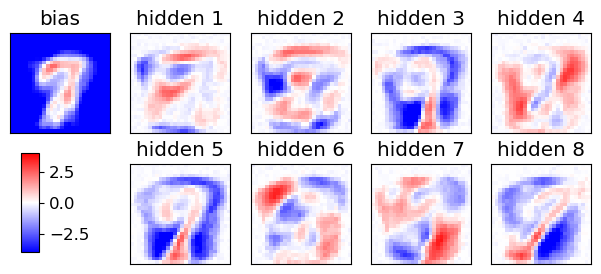

epoch 31 / 150  Nt: 5  N: 10  L: 8  rate: 0.004395973154362416  m: 0.5162154857889284 SPINS= False POTTS= False
epoch 32 / 150  Nt: 5  N: 10  L: 8  rate: 0.004375838926174496  m: 0.5173145353812891 SPINS= False POTTS= False
epoch 33 / 150  Nt: 5  N: 10  L: 8  rate: 0.0043557046979865776  m: 0.5184496193865141 SPINS= False POTTS= False
epoch 34 / 150  Nt: 5  N: 10  L: 8  rate: 0.004335570469798658  m: 0.5196207378046034 SPINS= False POTTS= False
epoch 35 / 150  Nt: 5  N: 11  L: 8  rate: 0.004315436241610738  m: 0.520827890635557 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

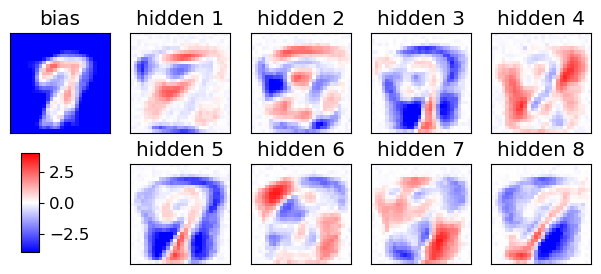

epoch 36 / 150  Nt: 5  N: 11  L: 8  rate: 0.004295302013422819  m: 0.5220710778793748 SPINS= False POTTS= False
epoch 37 / 150  Nt: 5  N: 11  L: 8  rate: 0.0042751677852348995  m: 0.5233502995360569 SPINS= False POTTS= False
epoch 38 / 150  Nt: 5  N: 11  L: 8  rate: 0.00425503355704698  m: 0.5246655556056034 SPINS= False POTTS= False
epoch 39 / 150  Nt: 5  N: 11  L: 8  rate: 0.00423489932885906  m: 0.526016846088014 SPINS= False POTTS= False
epoch 40 / 150  Nt: 5  N: 11  L: 8  rate: 0.004214765100671141  m: 0.5274041709832891 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

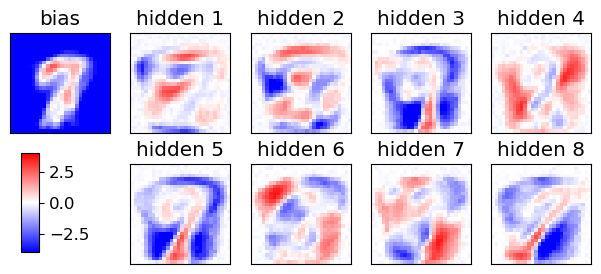

epoch 41 / 150  Nt: 5  N: 11  L: 8  rate: 0.0041946308724832215  m: 0.5288275302914283 SPINS= False POTTS= False
epoch 42 / 150  Nt: 5  N: 11  L: 8  rate: 0.004174496644295302  m: 0.5302869240124318 SPINS= False POTTS= False
epoch 43 / 150  Nt: 5  N: 11  L: 8  rate: 0.004154362416107383  m: 0.5317823521462998 SPINS= False POTTS= False
epoch 44 / 150  Nt: 5  N: 11  L: 8  rate: 0.004134228187919463  m: 0.5333138146930319 SPINS= False POTTS= False
epoch 45 / 150  Nt: 5  N: 11  L: 8  rate: 0.0041140939597315435  m: 0.5348813116526283 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

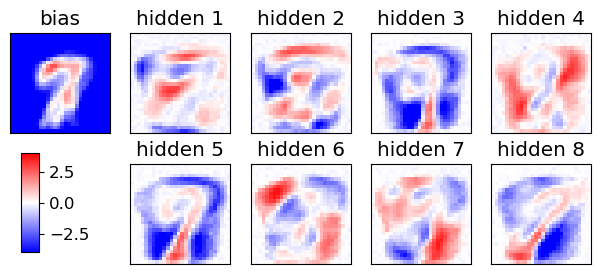

epoch 46 / 150  Nt: 5  N: 11  L: 8  rate: 0.004093959731543624  m: 0.5364848430250889 SPINS= False POTTS= False
epoch 47 / 150  Nt: 5  N: 11  L: 8  rate: 0.004073825503355705  m: 0.5381244088104139 SPINS= False POTTS= False
epoch 48 / 150  Nt: 5  N: 11  L: 8  rate: 0.004053691275167785  m: 0.5398000090086033 SPINS= False POTTS= False
epoch 49 / 150  Nt: 5  N: 12  L: 8  rate: 0.004033557046979866  m: 0.5415116436196568 SPINS= False POTTS= False
epoch 50 / 150  Nt: 5  N: 12  L: 8  rate: 0.004013422818791947  m: 0.5432593126435746 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

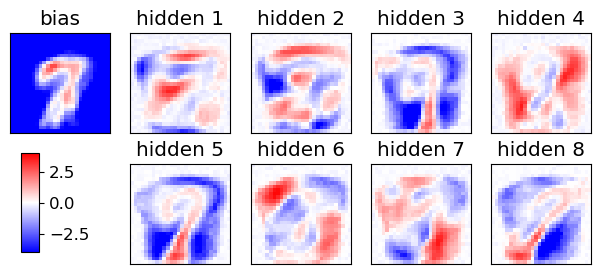

epoch 51 / 150  Nt: 5  N: 12  L: 8  rate: 0.003993288590604027  m: 0.5450430160803568 SPINS= False POTTS= False
epoch 52 / 150  Nt: 5  N: 12  L: 8  rate: 0.003973154362416107  m: 0.5468627539300032 SPINS= False POTTS= False
epoch 53 / 150  Nt: 5  N: 12  L: 8  rate: 0.003953020134228188  m: 0.5487185261925138 SPINS= False POTTS= False
epoch 54 / 150  Nt: 5  N: 12  L: 8  rate: 0.0039328859060402685  m: 0.5506103328678889 SPINS= False POTTS= False
epoch 55 / 150  Nt: 5  N: 12  L: 8  rate: 0.00391275167785235  m: 0.5525381739561281 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

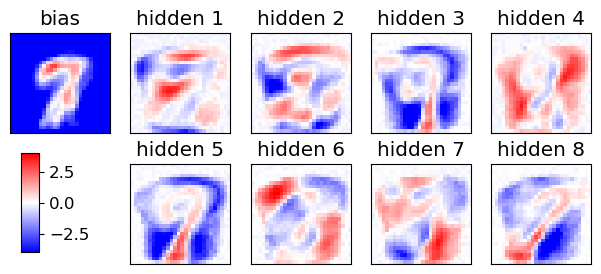

epoch 56 / 150  Nt: 5  N: 12  L: 8  rate: 0.0038926174496644295  m: 0.5545020494572317 SPINS= False POTTS= False
epoch 57 / 150  Nt: 5  N: 12  L: 8  rate: 0.0038724832214765102  m: 0.5565019593711995 SPINS= False POTTS= False
epoch 58 / 150  Nt: 5  N: 12  L: 8  rate: 0.0038523489932885905  m: 0.5585379036980316 SPINS= False POTTS= False
epoch 59 / 150  Nt: 5  N: 13  L: 8  rate: 0.003832214765100671  m: 0.560609882437728 SPINS= False POTTS= False
epoch 60 / 150  Nt: 5  N: 13  L: 8  rate: 0.003812080536912752  m: 0.5627178955902887 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

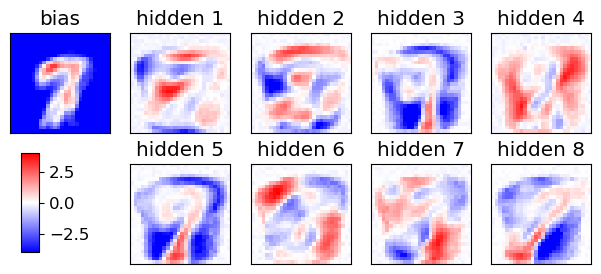

epoch 61 / 150  Nt: 5  N: 13  L: 8  rate: 0.003791946308724832  m: 0.5648619431557137 SPINS= False POTTS= False
epoch 62 / 150  Nt: 5  N: 13  L: 8  rate: 0.0037718120805369125  m: 0.5670420251340029 SPINS= False POTTS= False
epoch 63 / 150  Nt: 5  N: 13  L: 8  rate: 0.0037516778523489936  m: 0.5692581415251565 SPINS= False POTTS= False
epoch 64 / 150  Nt: 5  N: 13  L: 8  rate: 0.003731543624161074  m: 0.5715102923291744 SPINS= False POTTS= False
epoch 65 / 150  Nt: 5  N: 13  L: 8  rate: 0.003711409395973154  m: 0.5737984775460565 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

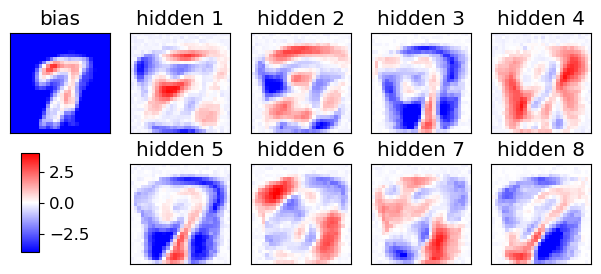

epoch 66 / 150  Nt: 5  N: 13  L: 8  rate: 0.0036912751677852353  m: 0.5761226971758029 SPINS= False POTTS= False
epoch 67 / 150  Nt: 5  N: 13  L: 8  rate: 0.0036711409395973156  m: 0.5784829512184136 SPINS= False POTTS= False
epoch 68 / 150  Nt: 5  N: 14  L: 8  rate: 0.003651006711409396  m: 0.5808792396738885 SPINS= False POTTS= False
epoch 69 / 150  Nt: 5  N: 14  L: 8  rate: 0.0036308724832214766  m: 0.5833115625422278 SPINS= False POTTS= False
epoch 70 / 150  Nt: 5  N: 14  L: 8  rate: 0.0036107382550335573  m: 0.5857799198234314 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

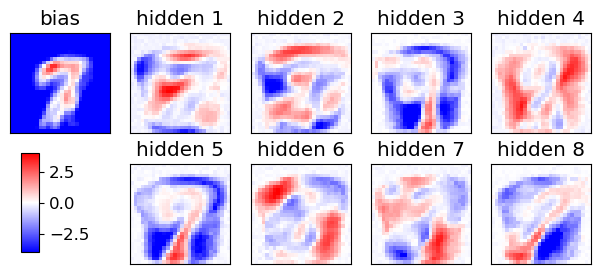

epoch 71 / 150  Nt: 5  N: 14  L: 8  rate: 0.0035906040268456375  m: 0.5882843115174992 SPINS= False POTTS= False
epoch 72 / 150  Nt: 5  N: 14  L: 8  rate: 0.0035704697986577182  m: 0.5908247376244313 SPINS= False POTTS= False
epoch 73 / 150  Nt: 5  N: 14  L: 8  rate: 0.003550335570469799  m: 0.5934011981442278 SPINS= False POTTS= False
epoch 74 / 150  Nt: 5  N: 14  L: 8  rate: 0.0035302013422818792  m: 0.5960136930768885 SPINS= False POTTS= False
epoch 75 / 150  Nt: 5  N: 14  L: 8  rate: 0.0035100671140939595  m: 0.5986622224224134 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

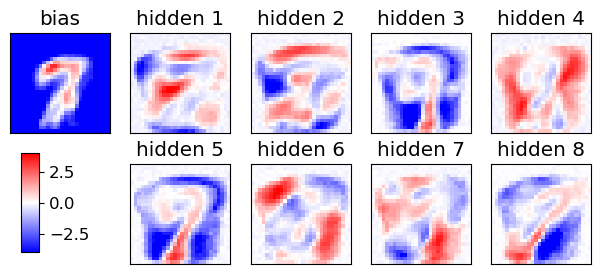

epoch 76 / 150  Nt: 5  N: 15  L: 8  rate: 0.00348993288590604  m: 0.6013467861808027 SPINS= False POTTS= False
epoch 77 / 150  Nt: 5  N: 15  L: 8  rate: 0.003469798657718121  m: 0.6040673843520562 SPINS= False POTTS= False
epoch 78 / 150  Nt: 5  N: 15  L: 8  rate: 0.003449664429530201  m: 0.606824016936174 SPINS= False POTTS= False
epoch 79 / 150  Nt: 5  N: 15  L: 8  rate: 0.003429530201342282  m: 0.6096166839331562 SPINS= False POTTS= False
epoch 80 / 150  Nt: 5  N: 15  L: 8  rate: 0.0034093959731543626  m: 0.6124453853430025 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

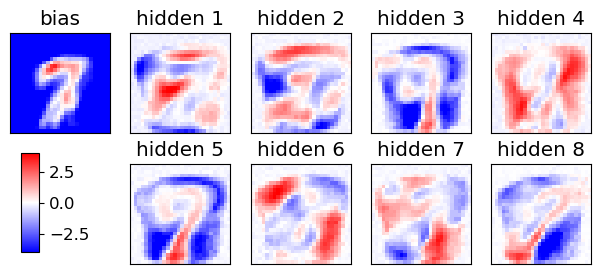

epoch 81 / 150  Nt: 5  N: 15  L: 8  rate: 0.003389261744966443  m: 0.6153101211657133 SPINS= False POTTS= False
epoch 82 / 150  Nt: 5  N: 15  L: 8  rate: 0.0033691275167785236  m: 0.6182108914012883 SPINS= False POTTS= False
epoch 83 / 150  Nt: 5  N: 16  L: 8  rate: 0.0033489932885906043  m: 0.6211476960497275 SPINS= False POTTS= False
epoch 84 / 150  Nt: 5  N: 16  L: 8  rate: 0.0033288590604026846  m: 0.624120535111031 SPINS= False POTTS= False
epoch 85 / 150  Nt: 5  N: 16  L: 8  rate: 0.0033087248322147653  m: 0.6271294085851988 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

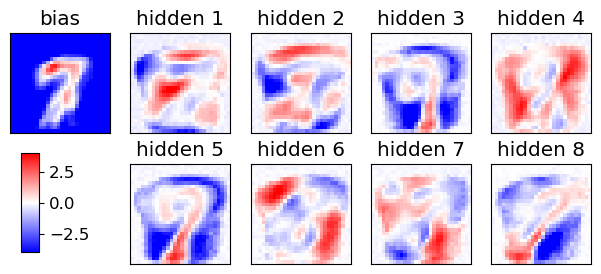

epoch 86 / 150  Nt: 5  N: 16  L: 8  rate: 0.003288590604026846  m: 0.630174316472231 SPINS= False POTTS= False
epoch 87 / 150  Nt: 5  N: 16  L: 8  rate: 0.0032684563758389263  m: 0.6332552587721274 SPINS= False POTTS= False
epoch 88 / 150  Nt: 5  N: 16  L: 8  rate: 0.0032483221476510065  m: 0.6363722354848881 SPINS= False POTTS= False
epoch 89 / 150  Nt: 5  N: 16  L: 8  rate: 0.0032281879194630872  m: 0.639525246610513 SPINS= False POTTS= False
epoch 90 / 150  Nt: 5  N: 17  L: 8  rate: 0.003208053691275168  m: 0.6427142921490023 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

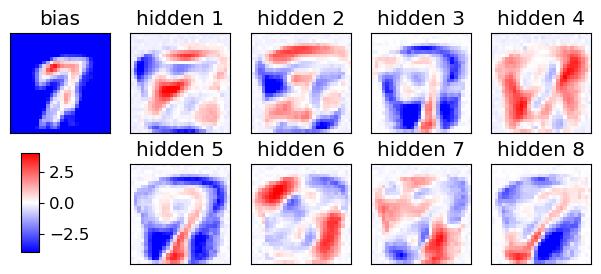

epoch 91 / 150  Nt: 5  N: 17  L: 8  rate: 0.0031879194630872482  m: 0.6459393721003559 SPINS= False POTTS= False
epoch 92 / 150  Nt: 5  N: 17  L: 8  rate: 0.003167785234899329  m: 0.6492004864645737 SPINS= False POTTS= False
epoch 93 / 150  Nt: 5  N: 17  L: 8  rate: 0.0031476510067114096  m: 0.6524976352416558 SPINS= False POTTS= False
epoch 94 / 150  Nt: 5  N: 17  L: 8  rate: 0.00312751677852349  m: 0.6558308184316022 SPINS= False POTTS= False
epoch 95 / 150  Nt: 5  N: 17  L: 8  rate: 0.0031073825503355706  m: 0.6592000360344129 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

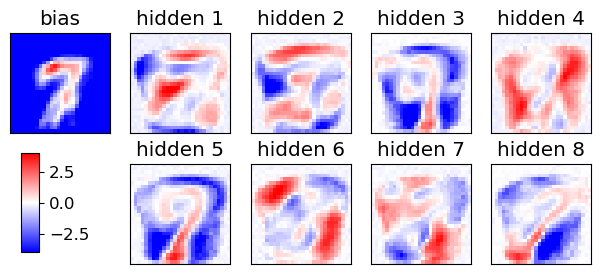

epoch 96 / 150  Nt: 5  N: 18  L: 8  rate: 0.0030872483221476513  m: 0.6626052880500879 SPINS= False POTTS= False
epoch 97 / 150  Nt: 5  N: 18  L: 8  rate: 0.0030671140939597316  m: 0.666046574478627 SPINS= False POTTS= False
epoch 98 / 150  Nt: 5  N: 18  L: 8  rate: 0.0030469798657718123  m: 0.6695238953200306 SPINS= False POTTS= False
epoch 99 / 150  Nt: 5  N: 18  L: 8  rate: 0.0030268456375838926  m: 0.6730372505742985 SPINS= False POTTS= False
epoch 100 / 150  Nt: 5  N: 18  L: 8  rate: 0.0030067114093959733  m: 0.6765866402414306 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

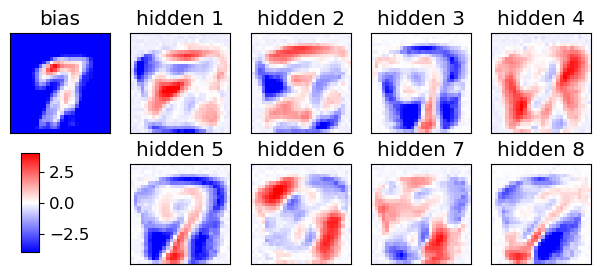

epoch 101 / 150  Nt: 5  N: 19  L: 8  rate: 0.0029865771812080536  m: 0.680172064321427 SPINS= False POTTS= False
epoch 102 / 150  Nt: 5  N: 19  L: 8  rate: 0.0029664429530201343  m: 0.6837935228142876 SPINS= False POTTS= False
epoch 103 / 150  Nt: 5  N: 19  L: 8  rate: 0.002946308724832215  m: 0.6874510157200127 SPINS= False POTTS= False
epoch 104 / 150  Nt: 5  N: 19  L: 8  rate: 0.0029261744966442953  m: 0.6911445430386018 SPINS= False POTTS= False
epoch 105 / 150  Nt: 5  N: 19  L: 8  rate: 0.002906040268456376  m: 0.6948741047700554 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

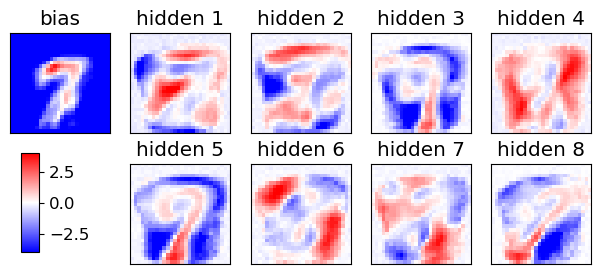

epoch 106 / 150  Nt: 5  N: 19  L: 8  rate: 0.0028859060402684567  m: 0.6986397009143732 SPINS= False POTTS= False
epoch 107 / 150  Nt: 5  N: 20  L: 8  rate: 0.002865771812080537  m: 0.7024413314715553 SPINS= False POTTS= False
epoch 108 / 150  Nt: 5  N: 20  L: 8  rate: 0.0028456375838926177  m: 0.7062789964416017 SPINS= False POTTS= False
epoch 109 / 150  Nt: 5  N: 20  L: 8  rate: 0.0028255033557046984  m: 0.7101526958245123 SPINS= False POTTS= False
epoch 110 / 150  Nt: 5  N: 20  L: 8  rate: 0.0028053691275167782  m: 0.7140624296202874 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

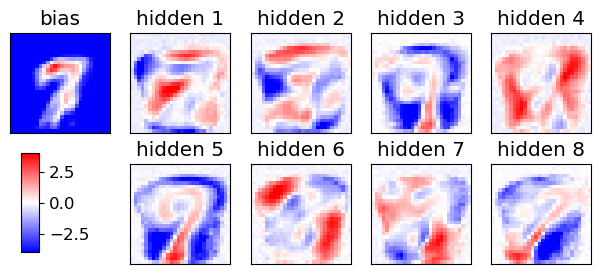

epoch 111 / 150  Nt: 5  N: 20  L: 8  rate: 0.002785234899328859  m: 0.7180081978289267 SPINS= False POTTS= False
epoch 112 / 150  Nt: 5  N: 21  L: 8  rate: 0.0027651006711409396  m: 0.7219900004504302 SPINS= False POTTS= False
epoch 113 / 150  Nt: 5  N: 21  L: 8  rate: 0.00274496644295302  m: 0.726007837484798 SPINS= False POTTS= False
epoch 114 / 150  Nt: 5  N: 21  L: 8  rate: 0.0027248322147651006  m: 0.73006170893203 SPINS= False POTTS= False
epoch 115 / 150  Nt: 5  N: 21  L: 8  rate: 0.0027046979865771813  m: 0.7341516147921265 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

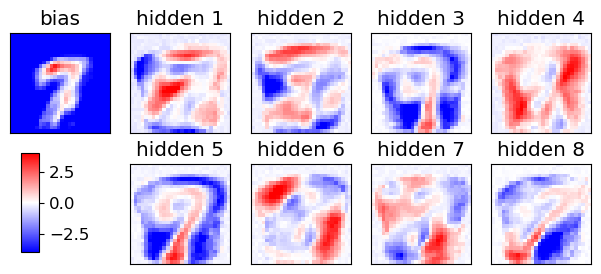

epoch 116 / 150  Nt: 5  N: 21  L: 8  rate: 0.0026845637583892616  m: 0.7382775550650872 SPINS= False POTTS= False
epoch 117 / 150  Nt: 5  N: 22  L: 8  rate: 0.0026644295302013423  m: 0.7424395297509121 SPINS= False POTTS= False
epoch 118 / 150  Nt: 5  N: 22  L: 8  rate: 0.002644295302013423  m: 0.7466375388496014 SPINS= False POTTS= False
epoch 119 / 150  Nt: 5  N: 22  L: 8  rate: 0.0026241610738255037  m: 0.7508715823611549 SPINS= False POTTS= False
epoch 120 / 150  Nt: 5  N: 22  L: 8  rate: 0.002604026845637584  m: 0.7551416602855727 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

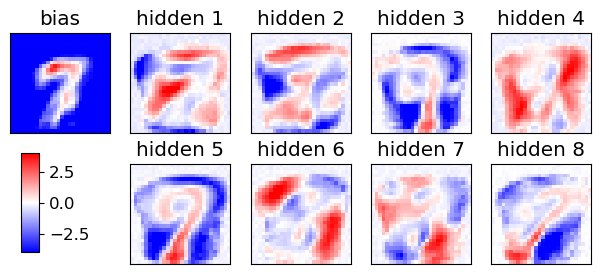

epoch 121 / 150  Nt: 5  N: 22  L: 8  rate: 0.0025838926174496647  m: 0.7594477726228548 SPINS= False POTTS= False
epoch 122 / 150  Nt: 5  N: 23  L: 8  rate: 0.002563758389261745  m: 0.7637899193730013 SPINS= False POTTS= False
epoch 123 / 150  Nt: 5  N: 23  L: 8  rate: 0.0025436241610738253  m: 0.7681681005360119 SPINS= False POTTS= False
epoch 124 / 150  Nt: 5  N: 23  L: 8  rate: 0.002523489932885906  m: 0.7725823161118869 SPINS= False POTTS= False
epoch 125 / 150  Nt: 5  N: 23  L: 8  rate: 0.0025033557046979867  m: 0.7770325661006261 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

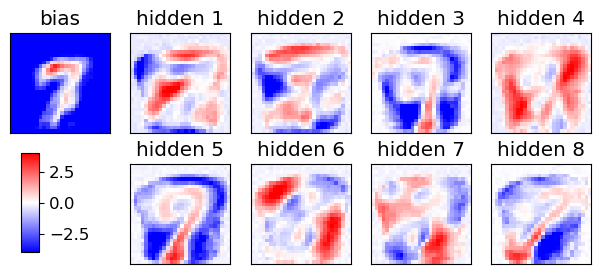

epoch 126 / 150  Nt: 5  N: 24  L: 8  rate: 0.002483221476510067  m: 0.7815188505022297 SPINS= False POTTS= False
epoch 127 / 150  Nt: 5  N: 24  L: 8  rate: 0.0024630872483221477  m: 0.7860411693166975 SPINS= False POTTS= False
epoch 128 / 150  Nt: 5  N: 24  L: 8  rate: 0.0024429530201342284  m: 0.7905995225440295 SPINS= False POTTS= False
epoch 129 / 150  Nt: 5  N: 24  L: 8  rate: 0.0024228187919463086  m: 0.795193910184226 SPINS= False POTTS= False
epoch 130 / 150  Nt: 5  N: 24  L: 8  rate: 0.0024026845637583893  m: 0.7998243322372867 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

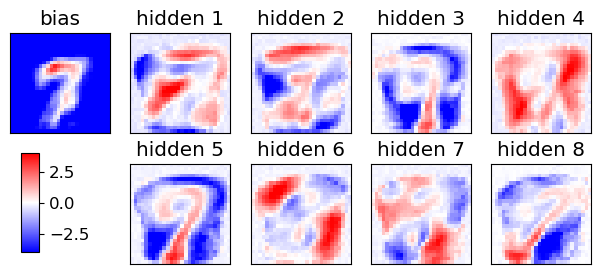

epoch 131 / 150  Nt: 5  N: 25  L: 8  rate: 0.00238255033557047  m: 0.8044907887032116 SPINS= False POTTS= False
epoch 132 / 150  Nt: 5  N: 25  L: 8  rate: 0.0023624161073825503  m: 0.8091932795820007 SPINS= False POTTS= False
epoch 133 / 150  Nt: 5  N: 25  L: 8  rate: 0.0023422818791946306  m: 0.8139318048736544 SPINS= False POTTS= False
epoch 134 / 150  Nt: 5  N: 25  L: 8  rate: 0.0023221476510067113  m: 0.8187063645781723 SPINS= False POTTS= False
epoch 135 / 150  Nt: 5  N: 26  L: 8  rate: 0.002302013422818792  m: 0.8235169586955543 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

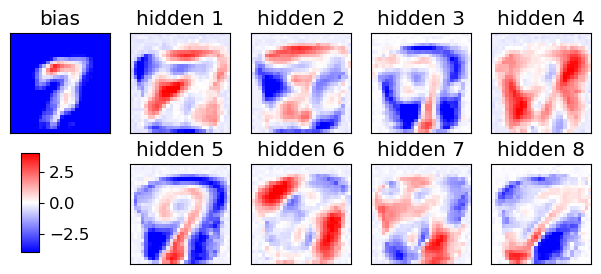

epoch 136 / 150  Nt: 5  N: 26  L: 8  rate: 0.0022818791946308723  m: 0.8283635872258006 SPINS= False POTTS= False
epoch 137 / 150  Nt: 5  N: 26  L: 8  rate: 0.002261744966442953  m: 0.8332462501689113 SPINS= False POTTS= False
epoch 138 / 150  Nt: 5  N: 26  L: 8  rate: 0.0022416107382550337  m: 0.8381649475248862 SPINS= False POTTS= False
epoch 139 / 150  Nt: 5  N: 27  L: 8  rate: 0.002221476510067114  m: 0.8431196792937254 SPINS= False POTTS= False
epoch 140 / 150  Nt: 5  N: 27  L: 8  rate: 0.0022013422818791947  m: 0.8481104454754291 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

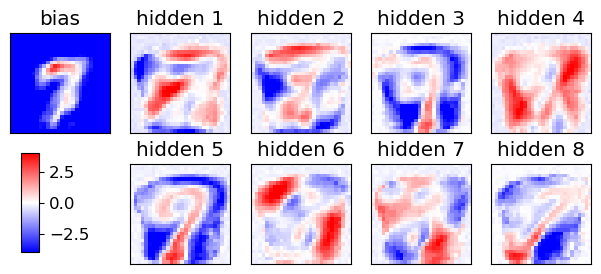

epoch 141 / 150  Nt: 5  N: 27  L: 8  rate: 0.0021812080536912754  m: 0.8531372460699969 SPINS= False POTTS= False
epoch 142 / 150  Nt: 5  N: 27  L: 8  rate: 0.0021610738255033557  m: 0.858200081077429 SPINS= False POTTS= False
epoch 143 / 150  Nt: 5  N: 28  L: 8  rate: 0.0021409395973154364  m: 0.8632989504977253 SPINS= False POTTS= False
epoch 144 / 150  Nt: 5  N: 28  L: 8  rate: 0.002120805369127517  m: 0.868433854330886 SPINS= False POTTS= False
epoch 145 / 150  Nt: 5  N: 28  L: 8  rate: 0.0021006711409395974  m: 0.873604792576911 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

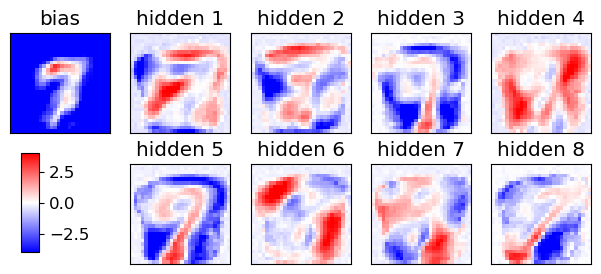

epoch 146 / 150  Nt: 5  N: 28  L: 8  rate: 0.0020805369127516776  m: 0.8788117652358003 SPINS= False POTTS= False
epoch 147 / 150  Nt: 5  N: 29  L: 8  rate: 0.0020604026845637584  m: 0.8840547723075538 SPINS= False POTTS= False
epoch 148 / 150  Nt: 5  N: 29  L: 8  rate: 0.002040268456375839  m: 0.8893338137921716 SPINS= False POTTS= False
epoch 149 / 150  Nt: 5  N: 29  L: 8  rate: 0.0020201342281879193  m: 0.8946488896896536 SPINS= False POTTS= False
epoch 150 / 150  Nt: 5  N: 30  L: 8  rate: 0.002  m: 0.9 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

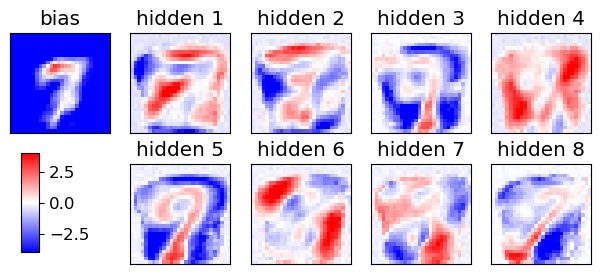

-149.26871175680577
END of learning phase _20250328_2313


In [30]:
for seed in [1]:#, 12, 123, 1234, 12345, 123457]:
    np.random.seed(seed)
    
    # initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
    w = sigma * np.random.randn(D,L)
    # using Hinton initialization of visible biases
    a = Hinton_bias_init(data)
    # hidden biases initialized to zero
    b = np.zeros(L)
    print(f"Nepoch={Nepoch}\nNmini={Nmini}")
    # recording history of weights ("E" means epoch)
    wE,aE,bE=np.zeros((Nepoch+1,D,L)),np.zeros((Nepoch+1,D)),np.zeros((Nepoch+1,L)) 
    wE[0],aE[0],bE[0]=np.copy(w),np.copy(a),np.copy(b)
    gwE,gw2E,gwE_d,gwE_m = np.zeros_like(wE),np.zeros_like(wE),np.zeros_like(wE),np.zeros_like(wE)
    gaE,ga2E,gaE_d,gaE_m = np.zeros_like(aE),np.zeros_like(aE),np.zeros_like(aE),np.zeros_like(aE)
    gbE,gb2E,gbE_d,gbE_m = np.zeros_like(bE),np.zeros_like(bE),np.zeros_like(bE),np.zeros_like(bE)
    miniE = np.zeros(Nepoch+1)
    pzE=np.zeros((Nepoch+1,Nz))
    
    if m > 0: 
        bw = np.zeros_like(w)
        ba = np.zeros_like(a)
        bb = np.zeros_like(b)
    
    if GRAD=="RMSprop": 
        gw2,ga2,gb2 = np.zeros_like(w),np.zeros_like(a),np.zeros_like(b)
    
    elif GRAD=='Adam':
        mw, ma, mb = np.zeros_like(w), np.zeros_like(a), np.zeros_like(b)
        vw, va, vb = np.zeros_like(w), np.zeros_like(a), np.zeros_like(b)

    
    indices=np.arange(Nd).astype("int")
    plot_weights_bias(wE, aE, 0, L, cols=L//2, save=False)
    
    # for the plot with panels
    Ncols=min(8,max(2,L//2))
    
    if POTTS: print("Starting the training, POTTS=True")
    else: print("Starting the training")
    print(datetime.datetime.now().strftime("_%Y%m%d_%H%M"))
    
    configurations = generate_configurations(L)
    log_likelihoods = []
    lista_epoch_grafico = []
    # Note: here an epoch does not analyze the whole dataset
    for epoch in range(1,1+Nepoch):
        # q maps epochs to interval [0,1]
        q = (epoch-1.)/(Nepoch-1.) 
        # N, size of the mini batch
        # stays closer to N_ini for some time, then it progressively accelerates toward N_fin
        N = int(N_ini + (N_fin-N_ini)*(q**2))
        #  l_rate interpolates between initial and final value
        l_rate = l_rate_ini + (l_rate_fin-l_rate_ini)*q
        mt = m + (M-m) * (q**2)
    
        for mini in range(Nmini):
            # initializitation for averages in minibatch
            # visible variables "v" --> "x"
            #  hidden variables "h" --> "z"
            x_data, x_model = np.zeros(D),np.zeros(D)
            z_data, z_model = np.zeros(L),np.zeros(L)
            xz_data,xz_model= np.zeros((D,L)),np.zeros((D,L))
            pz = np.zeros(L)
    
            # Minibatch of size N: points randomply picked (without repetition) from data
            selected = np.random.choice(indices,N,replace=False)
           # if epoch==1 and mini<=3: print(selected)
    
            for k in range(N):
                ###################################
                x0 = data[selected[k]]
                # positive CD phase: generating z from x[k]
                z = CD_step(x0,w,b,a_func=active,POTTS=POTTS)
                x_data  += x0
                z_data  += z
                xz_data += np.outer(x0,z)
                # fantasy
                zf=np.copy(z)
                # Contrastive divergence with Nt steps
                for t in range(Nt):
                    # negative CD pzase: generating fantasy xf from fantasy zf
                    xf = CD_step(zf,w.T, a, a_func=active)
                    # positive CD phase: generating fantasy zf from fantasy xf 
                    zf = CD_step(xf,w,b,a_func=active,POTTS=POTTS)
                x_model += xf
                z_model += zf
                xz_model+= np.outer(xf,zf)
                # recording probability of encoding in z-space, if POTTS
                if POTTS: pz[zf]+=1
                ###################################
    
            # gradient of the likelihood: follow it along its positive direction
            gw_d,gw_m = xz_data/N, xz_model/N
            ga_d,ga_m = x_data/N, x_model/N
            gb_d,gb_m = z_data/N, z_model/N
            gw=np.copy(gw_d - gw_m)
            ga=np.copy(ga_d - ga_m)
            gb=np.copy(gb_d - gb_m)
    
            # gradient ascent step
            if GRAD=="RMSprop":
                # RMSprop gradient ascent
                gw2 = beta*gw2+(1-beta)*np.square(gw)
                ga2 = beta*ga2+(1-beta)*np.square(ga)
                gb2 = beta*gb2+(1-beta)*np.square(gb)
                if m > 0:
                    bw = mt * bw + gw / sqrt(epsilon+gw2)
                    ba = mt * ba + ga / sqrt(epsilon+ga2)
                    bb = mt * bb + gb / sqrt(epsilon+gb2)
                    
                    w += l_rate * bw
                    a += l_rate * ba
                    b += l_rate * bb
                else:
                    w += l_rate*gw/sqrt(epsilon+gw2)
                    a += l_rate*ga/sqrt(epsilon+ga2)
                    b += l_rate*gb/sqrt(epsilon+gb2)
                    
                
            elif GRAD=='SGD': 
                # defaulting to the vanilla stochastic gradient ascent (SGD)
                if m > 0:
                    bw = mt * bw + gw
                    ba = mt * bw + ga
                    bb = mt * bw + gb
                    gw = bw, ga = ba, gb = bb
                w += l_rate*gw
                a += l_rate*ga
                b += l_rate*gb

            else:
                # Adam
                mw = beta1 * mw + (1 - beta1) * gw
                ma = beta1 * ma + (1 - beta1) * ga
                mb = beta1 * mb + (1 - beta1) * gb
                
                vw = beta2 * vw + (1 - beta2) * np.square(gw)
                va = beta2 * va + (1 - beta2) * np.square(ga)
                vb = beta2 * vb + (1 - beta2) * np.square(gb)
                
                mwhat = mw / (1 - beta1 ** (mini + 1))
                mahat = ma / (1 - beta1 ** (mini + 1))
                mbhat = mb / (1 - beta1 ** (mini + 1))
                
                vwhat = vw / (1 - beta2 ** (mini + 1))
                vahat = va / (1 - beta2 ** (mini + 1))
                vbhat = vb / (1 - beta2 ** (mini + 1))
                

                w += l_rate * mwhat / sqrt(epsilon + vwhat)
                a += l_rate * mahat / sqrt(epsilon + vahat)
                b += l_rate * mbhat / sqrt(epsilon + vbhat)

                
            # regularization (LASSO)
            if gamma>0.:
                w -= (gamma*l_rate)*sign(w)
                a -= (gamma*l_rate)*sign(a)
                b -= (gamma*l_rate)*sign(b)
    
        wE[epoch],gwE[epoch],gwE_d[epoch],gwE_m[epoch]=np.copy(w),np.copy(gw),np.copy(gw_d),np.copy(gw_m)
        aE[epoch],gaE[epoch],gaE_d[epoch],gaE_m[epoch]=np.copy(a),np.copy(ga),np.copy(ga_d),np.copy(ga_m)
        bE[epoch],gbE[epoch],gbE_d[epoch],gbE_m[epoch]=np.copy(b),np.copy(gb),np.copy(gb_d),np.copy(gb_m)
        miniE[epoch]=N
        if POTTS: pzE[epoch] = pz/np.sum(pz)
        print("epoch",epoch,"/",Nepoch," Nt:",Nt," N:",N," L:",L, " rate:",l_rate," m:",mt,"SPINS=",SPINS,"POTTS=",POTTS)
        if epoch%5==0 or epoch==Nepoch: plot_weights_bias(wE, aE, epoch, L, cols=Ncols, save=False)
        if epoch%1000==0 or epoch==Nepoch:
            partition = partition_function(a,w,b,configurations)
            log_likelihood = compute_log_likelihood(partition,data, a=a, b=b, w=w,configurations=configurations)
            print(log_likelihood)
            with open((llh_file := f'newruns/llh/{str_simul}_SP{SPINS}_L{L}_act{active}_gam{gamma}_grad{GRAD}_steps{Nt}_epochs{Nepoch}_minis{Nmini}_Nini{N_ini}_Nfin{N_fin}_m{m}_M{M}_lri{l_rate_ini}_lrf{l_rate_fin}'), 'a') as add:
                print(log_likelihood, file=add)
    print("END of learning phase", datetime.datetime.now().strftime("_%Y%m%d_%H%M"))
    for sa, ve in zip(['w', 'a', 'b'], [wE, aE, bE]): np.save(f'newruns/weights/{str_simul}_SP{SPINS}_L{L}_act{active}_gam{gamma}_grad{GRAD}_steps{Nt}_epochs{Nepoch}_minis{Nmini}_Nini{N_ini}_Nfin{N_fin}_m{m}_M{M}_lri{l_rate_ini}_lrf{l_rate_fin}___{sa}.npy', ve)

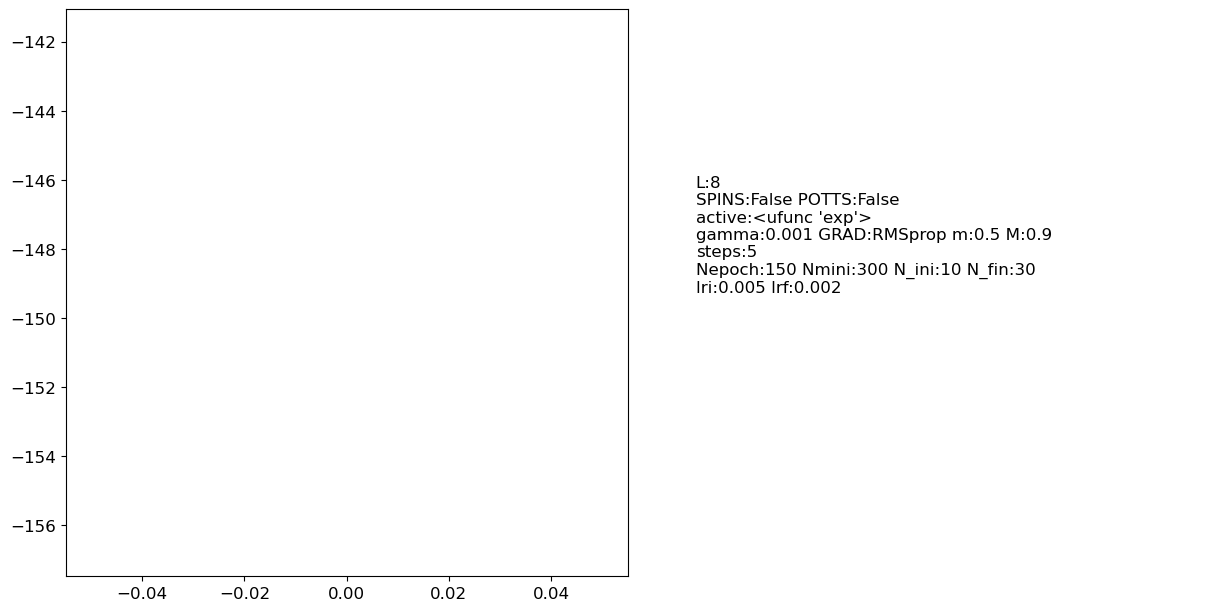

In [31]:
stringa = f'L:{L}\nSPINS:{SPINS} POTTS:{POTTS}\nactive:{active}\ngamma:{gamma} GRAD:{GRAD} m:{m} M:{M}\nsteps:{Nt}\nNepoch:{Nepoch} Nmini:{Nmini} N_ini:{N_ini} N_fin:{N_fin}\nlri:{l_rate_ini} lrf:{l_rate_fin}'

fig, ax = plt.subplots(1,2, figsize=(12,6), layout='constrained')

plot_stuff = np.loadtxt(llh_file)
ax[0].plot(plot_stuff)
#ax[0].set_xticks(np.arange(0, len(llh_file) + 1, 5))
ax[1].set_axis_off()
ax[1].text(.1,.5, stringa)
fig.savefig('newruns/img/' + f'L-{L}_SPINS-{SPINS}_POTTS-{POTTS}_active-{active}_gamma-{gamma}_GRAD-{GRAD}_m-{m}_M-{M}_steps-{Nt}_Nepoch-{Nepoch}_Nmini-{Nmini}_N_ini-{N_ini}_N_fin-{N_fin}' + '.png')
plt.show()

## Model scores
We plot the scores related to the 6 best models that we chose. We see that we get for all models approximately the same error bars and the same result.
We also note that five out of six models have as hyperparameter for the optimizer the value 'RMSprop', which indicates that maybe this value could be better than 'SGD'.


In [32]:
llh_list = []
file_names = []
with os.scandir() as files:
    for file in files:
        if file.name.startswith('llh') and file.name.endswith('.txt'):
            llh_list.append(np.loadtxt(file.name, skiprows=2))
            file_names.append(file.name)
print(file_names)

[]


|Model|L|SPIN|POTTS|gamma|Nt|Nepoch|Nmini|Nini|Nfin|Grad|
|---|---|---|---|---|---|---|---|---|---|---|
|0|7|False|False|0.001|4|300|30|5|100|RMSprop|
|1|10| False| False|0.001| 1| 200| 10| 5|325| RMSprop|
|2|5|False|False|0.001|2|190|45|10|450|SGD|
|3|10|False|True|0.01|1|200|10|5|10|RMSprop|
|4|10| False| False|0.01| 1| 200| 10| 5| 10| RMSprop|
|5|10|False|False|0.001|7|350|10|5|325|RMSprop|


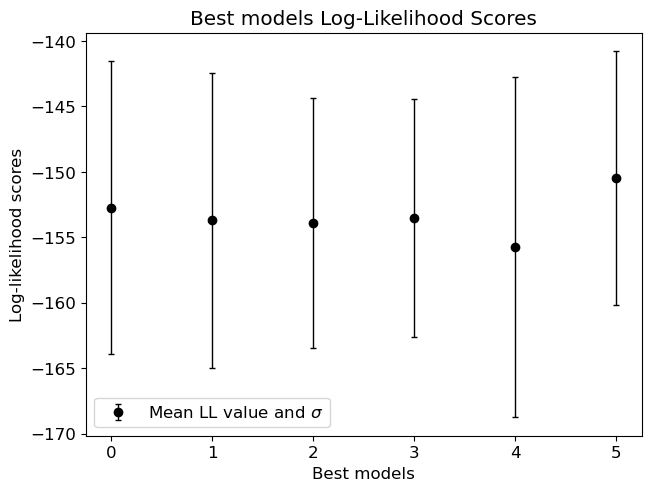

In [17]:
fig, ax = plt.subplots(layout='constrained')
ax.errorbar(range(len(llh_list)), np.mean(llh_list, axis=0), yerr=np.std(llh_list, axis=0), fmt='ok', lw=1, capsize=2, label='Mean LL value and $\\sigma$')
plt.title('Best models Log-Likelihood Scores')
plt.ylabel('Log-likelihood scores')
plt.xlabel('Best models')
plt.legend()
plt.show()

## Test generative power of the best model

Here we use model 5 to generate and show new data.

<Figure size 640x480 with 0 Axes>

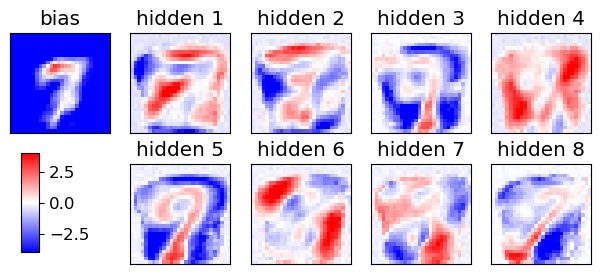

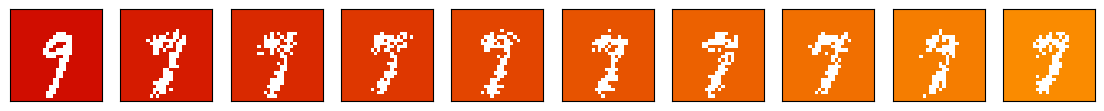

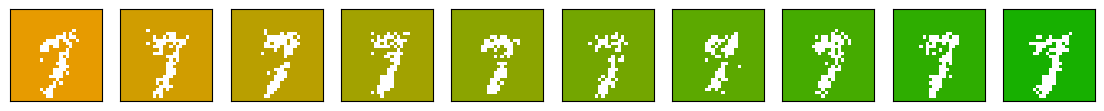

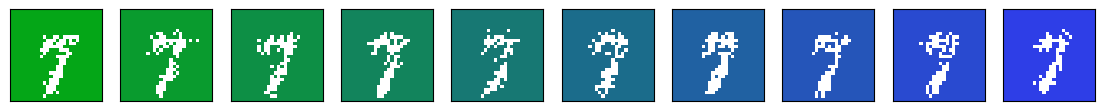

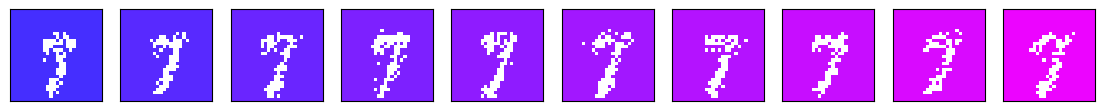

L: 8     amplification of weights: 1 lab 9


In [107]:
ee=-1 ##
NN=200
traj_x,traj_z = np.zeros((NN+2,D)), np.zeros((NN+2,L))
xf=np.copy(data[(danum := np.random.randint(Nd))])
labf=label[danum]
traj_x[0]=np.copy(xf)

# AF: multiply weights and biases by a number >1 to achieve a more deterministic behavior,
# equivalent to lower the temperature in a Boltzmann weight -> select lowest energies
# Note: here, this is done in the negative CD step only
AF=1

for t in range(NN):
    t1=t+1
    # positive CD phase: generating fantasy zf from fantasy xf
    zf = CD_step(xf,1*wE[ee],1*bE[ee], a_func=active, POTTS=POTTS)
    traj_z[t] = np.copy(zf)
    # negative CD pzase: generating fantasy xf from fantasy zf
    xf = CD_step(zf,AF*wE[ee].T, AF*aE[ee], a_func=active)
    traj_x[t1] = np.copy(xf)


plot_weights_bias(wE, aE, Nepoch, L, cols=Ncols, save=False)

col0,col1,col2,col3,col4=(0.8,0,0,1),(1,0.6,0,1),(0,.7,0,1),(0.2,0.2,1,1),(1,0,1,1)
show_MNIST(traj_x[0:],Nex=10,colors=(col0,col1))
show_MNIST(traj_x[10:],Nex=10,colors=(col1,col2))
show_MNIST(traj_x[20:],Nex=10,colors=(col2,col3))
show_MNIST(traj_x[40:],Nex=10,colors=(col3,col4))
print("L:",L,"    amplification of weights:",AF, 'lab', labf)

In [108]:
travj_x = np.mean(traj_x, axis=0)
bintravj_x = np.where(travj_x > .5, 1, 0)

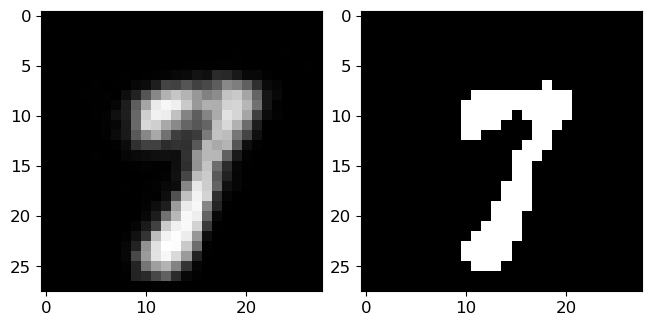

In [109]:
fig, ax = plt.subplots(1, 2, layout='constrained')
ax[0].imshow(travj_x.reshape(28,28), cmap='gray')
ax[1].imshow(bintravj_x.reshape(28,28), cmap='gray')
plt.show()


In [25]:
import os
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt
import re

folder_path = "img/"
# regex
pattern = re.compile(r"LLH_epoch150_L(\d)_CD(\d+)_lr0.05.png")

files = [
    (f, int(match.group(1)), int(match.group(2)), os.path.join(folder_path, f))
    for f in os.listdir(folder_path)
    if (match := pattern.match(f)) 
]

# Sort by L first, then CD
files.sort(key=lambda x: (x[1], x[2]))
# Extract only filenames
sorted_filenames = [f[0] for f in files]

row,cols = 5,6
fig,axes = plt.subplots(row,cols, figsize=(15,10), layout='constrained', dpi=1000)
axes = axes.flatten()
for i, img in enumerate(sorted_filenames[:row*cols]):
    image = Image.open('img/' +img)
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()